In [5]:
path = '/home/flomik/Desktop/Code-PHD/3_layers_integration/results/network/'
name = 'AA_3_layers_filt_consensus'

In [6]:
import sklearn, leidenalg, itertools, random
import pandas as pd
import numpy as np
import igraph as ig
import sklearn.neighbors
import scipy as sp
from statsmodels.stats.multitest import multipletests
import gseapy as gp

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
def my_correlation(file):
    """
        perform spearman correlation from file of values
        Args:
            file (str): pandas.core.frame.DataFrame with samples as column and features as rows
        Returns:
            PRmatrix(str): Correlation table
    """
    Rmatrix, Pmatrix= sp.stats.spearmanr(file.T)
    Rmatrix=pd.DataFrame(Rmatrix, index=data.index.copy(), columns=data.index.copy())
    Pmatrix=pd.DataFrame(Pmatrix, index=data.index.copy(), columns=data.index.copy())

    ###Prepares R and P matrices
    Psquared=Pmatrix.where(np.triu(np.ones(Pmatrix.shape),1).astype(np.bool))
    Psquared.columns.name='Feat2'
    Pmatrix=Pmatrix.stack()
    Pmatrix.index.names=['v1','v2']
    Pmatrix=Pmatrix.reset_index()
    Pmatrix.columns=['feat1','feat2','P']

    Rmatrix=Rmatrix.where(np.triu(np.ones(Rmatrix.shape),1).astype(np.bool))
    Rmatrix.columns.name='Feat2'
    Rmatrix=Rmatrix.stack()
    Rmatrix.index.names=['v1','v2'] #Avoid stacked names colliding
    Rmatrix=Rmatrix.reset_index()
    Rmatrix.columns=['feat1','feat2','R']

    PRmatrix=pd.merge(Rmatrix.copy(), Pmatrix.copy(), on=['feat1','feat2']) #Correlation matrix with both R and P
    PRmatrix=PRmatrix.loc[PRmatrix.feat1!=PRmatrix.feat2].dropna()
    
    ### Calculate FDR 
    FDR=pd.DataFrame(multipletests(PRmatrix['P'], method='fdr_bh', alpha=0.01)[1], columns=['FDR'])
    PRmatrix=pd.concat([ PRmatrix, FDR], axis=1)
    
    return(PRmatrix)

In [8]:
## load data
lip=pd.read_csv('/home/flomik/Desktop/Code-PHD/3_layers_integration/processing/data_lip_filt_SNF.csv', index_col=0)
met=pd.read_csv('/home/flomik/Desktop/Code-PHD/3_layers_integration/processing/data_met_filt_SNF.csv', index_col=0)
mi=pd.read_csv('/home/flomik/Desktop/Code-PHD/3_layers_integration/processing/data_mi_filt_SNF.csv', index_col=0)

In [9]:
a = len(lip.columns)
b = len(met.columns)
c = len(mi.columns)
a + b + c

1626

In [10]:
## make table conversion
conv_1 = pd.DataFrame({'feat1':lip.columns,
                   'type_1': ["lip"]*len(lip.columns),
                  }, columns = ['feat1', 'type_1'])
conv_2 = pd.DataFrame({'feat1':met.columns,
                   'type_1': ["met"]*len(met.columns),
                  }, columns = ['feat1', 'type_1'])
conv_3 = pd.DataFrame({'feat1':mi.columns,
                   'type_1': ["mic"]*len(mi.columns),
                  }, columns = ['feat1', 'type_1'])
conv = pd.concat([conv_1, conv_2, conv_3])

In [11]:
input = path + 'type_features' + name + '.csv'
conv.to_csv(input, index=False)

In [12]:
## Set empty dataframe
df= pd.DataFrame(columns = ['Comp', 'Comp_type', 'R', 'I'])
df

,Comp,Comp_type,R,I


In [13]:
PRmatrix= pd.read_csv('/home/flomik/Desktop/Code-PHD/3_layers_integration/processing/final_list', sep = '_')

In [14]:
PRmatrix.head()

,feat1,feat2,R
0,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),0.862100
1,(12 or 13)-methylmyristate (a15:0 or i15:0),(16 or 17)-methylstearate (a19:0 or i19:0),0.806517
2,(12 or 13)-methylmyristate (a15:0 or i15:0),(2 or 3)-decenoate (10:1n7 or n8),0.579352
3,(12 or 13)-methylmyristate (a15:0 or i15:0),10-heptadecenoate (17:1n7),0.755273
4,(12 or 13)-methylmyristate (a15:0 or i15:0),10-nonadecenoate (19:1n9),0.801560


In [15]:
fdr_pos_mat=PRmatrix.loc[PRmatrix['R']>0]
fdr_neg_mat=PRmatrix.loc[PRmatrix['R']<0]
PRmatrix=PRmatrix.loc[PRmatrix.isin(pd.unique(fdr_pos_mat[['feat1','feat2']].values.flatten())).sum(1)==2,]

In [16]:
fdr_pos_mat.shape

(131863, 3)

In [17]:
fdr_neg_mat.shape

(0, 3)

In [18]:
input = path + 'network_correlation_positive_' + name +'.csv'
fdr_pos_mat.to_csv(input, index=False)
input = path + 'network_correlation_positive_' + name +'.txt'
fdr_pos_mat.to_csv(input, sep='\t', mode='a')
input = path + 'network_correlation_positive_' + name +'.xlsx'
fdr_pos_mat.to_excel(input, index = False)

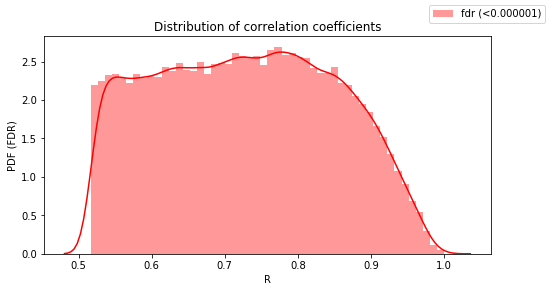

In [19]:
shortPR=PRmatrix.copy().loc[:,['feat1','feat2','R']]
shortPR=shortPR.loc[shortPR.feat1!=shortPR.feat2]

fig=plt.figure(figsize=(8,4))
g=sns.distplot(shortPR['R'][shortPR['R']!=0], color='r');
g.set(ylabel='PDF (FDR)')

fig.legend(labels=['fdr (<0.000001)']);
plt.xlabel('R')
plt.title('Distribution of correlation coefficients')
input = path + 'distribution_corr_coeff_'+ name + 'svg'
plt.savefig(input, format='svg', dpi=1200)

plt.show()

In [20]:
pos_w=ig.Graph.TupleList([tuple(x) for x in fdr_pos_mat.values], directed=False, edge_attrs=['w'])

#negative association, weighted
neg_w=ig.Graph.TupleList([tuple(x) for x in fdr_neg_mat.values], directed=False, edge_attrs=['w'])

#random network, unweighted, node and edge number based on a network of the same size
randomG=ig.Graph.Erdos_Renyi(
    n=pos_w.vcount(), 
    m=pos_w.ecount(), directed=False, loops=False)

randomG_2=ig.Graph.Erdos_Renyi(
    n=neg_w.vcount(), 
    m=neg_w.ecount(), directed=False, loops=False)

In [21]:
#function to get graph properties, takes a few minutes to run
def graph_prop(input_graph):
    ncount=nn.vcount()
    ecount=nn.ecount()
    diameter=nn.diameter()
    av_path=nn.average_path_length()
    dens=nn.density()
    clustering=nn.transitivity_undirected() #this is the global clustering coefficient
    conn=nn.is_connected()
    min_cut=nn.mincut_value()
    out=pd.DataFrame([ncount, ecount, diameter, av_path, dens, clustering, conn, min_cut],
                 index=['node_count','edge_count','diameter','av_path_length','density','clustering_coef','connected?','minimum_cut']).T
    return(out)

#summarizing graph properties
network_stats=pd.DataFrame()
for nn in [pos_w, neg_w, randomG, randomG_2]:
    network_stats=pd.concat([network_stats,graph_prop(nn)])
    
network_stats.index=['pos_w','neg_w', 'random', 'random_2']
network_stats

,node_count,edge_count,diameter,av_path_length,density,clustering_coef,connected?,minimum_cut
pos_w,1324,131863,18,3.6814,0.150558,0.839596,False,0
neg_w,0,0,0,NaN,NaN,NaN,True,0
random,1324,131863,2,1.84944,0.150558,0.150685,True,159
random_2,0,0,0,NaN,NaN,NaN,True,0


IndexError: list index out of range

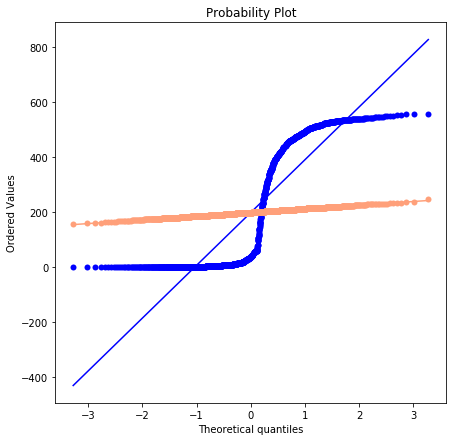

In [22]:
fig, ax = plt.subplots(figsize=(7, 7))
# ax.set(yscale='log', xscale='log')
p=sp.stats.probplot(pos_w.degree(), plot=ax)
k=sp.stats.probplot(neg_w.degree(), plot=ax)
r=sp.stats.probplot(randomG.degree(), plot=ax)
s=sp.stats.probplot(randomG_2.degree(), plot=ax)

col=['blue','','lightsalmon','','green', '','red']
for x in np.arange(0,7,2):
    ax.get_lines()[x].set_markerfacecolor(col[x])
    ax.get_lines()[x].set_markeredgewidth(0)
    ax.get_lines()[x+1].set_color(col[x])


fig.legend(labels=['pos_w','pos_w','neg_w','neg_w','random','random', 'random_2','random_2']);

ax.set(xlabel='Data quantiles', ylabel='observed degree (k)')
input = path + 'Networks_degree_' + name + '.svg'
plt.savefig(input, format='svg', dpi=1200)
plt.show()

In [54]:
pos_w_comm = leidenalg.find_partition(pos_w, leidenalg.CPMVertexPartition, weights='w',resolution_parameter=0.4)

In [32]:
leidenalg.ModularityVertexPartition
leidenalg.CPMVertexPartition

leidenalg.VertexPartition.CPMVertexPartition

In [33]:
def Average(lst): 
    return sum(lst) / len(lst)

In [46]:
metabolites = pd.Series(pos_w.vs['name'])
len(metabolites)
for i in range(19):
    print(len(metabolites[pos_w_comm[i]]))

306
98
64
47
31
27
18
12
11
9
9
9
8
7
6
5
5
5
5


In [55]:
## MSEA + centrality
cutoff = 0.1

network =[]
community = []
connectivity = []
communities_stats = []
n_metabolites = []
transitivity = []

tot_terms_met = []
tot_terms_lip = []
tot_terms_mic = []


tot_nb =[]

c = 0

d = pd.DataFrame()

net = [pos_w]
com_net = [pos_w_comm]
names = ['pos_w']

for j in [0]:
    average = []
    a = 1
    terms_enriched = []
    for i in com_net[j]:
        if(len(i)<30):
            continue
        c = i
        degree = pd.Series(net[j].degree())
        metabolites = pd.Series(net[j].vs['name'])
        degree = degree[c]
        metabolites = metabolites[c]
        metabolites = metabolites.tolist()
        
        if (len(conv_2[conv_2['feat1'].isin(metabolites)]) > 1):
            enr = gp.enrichr(gene_list= metabolites,description= "Metabolites" + str(a),
                       gene_sets="/home/flomik/Desktop/Code-PHD/3_layers_integration/processing/Metabolon_met.gmt",
                       outdir='/home/flomik/Desktop/Code-PHD/3_layers_integration/results/MSEA_Metabolites',cutoff=0.5,verbose=True, background  = 841)
            results=enr.results.sort_values('Adjusted P-value', ascending=True)
            results=results.loc[results['Adjusted P-value']<cutoff,]
            terms_enriched = results['Term'].tolist()
            terms_enriched = terms_enriched
            terms_enriched = ','.join(terms_enriched)
            tot_terms_met.append(terms_enriched)
        else :
            tot_terms_met.append('Not')
        
        if (len(conv_1[conv_1['feat1'].isin(metabolites)]) > 1):
            enr = gp.enrichr(gene_list= metabolites,description= "Lipids" + str(a),
                       gene_sets="/home/flomik/Desktop/Code-PHD/3_layers_integration/processing/Metabolon_lip.gmt",
                       outdir='/home/flomik/Desktop/Code-PHD/3_layers_integration/results/MSEA_Lipids',cutoff=0.5,verbose=True, background  = 1143)
            results=enr.results.sort_values('Adjusted P-value', ascending=True)
            results=results.loc[results['Adjusted P-value']<cutoff,]
            terms_enriched = results['Term'].tolist()
            terms_enriched = terms_enriched
            terms_enriched = ','.join(terms_enriched)
            tot_terms_lip.append(terms_enriched)
        else :
            tot_terms_lip.append('Not')
        
        if (len(conv_3[conv_3['feat1'].isin(metabolites)]) > 1):
            enr = gp.enrichr(gene_list= metabolites,description= "Microbiome" + str(a),
                       gene_sets="/home/flomik/Desktop/Code-PHD/3_layers_integration/processing/Metabolon_mic.gmt",
                       outdir='/home/flomik/Desktop/Code-PHD/3_layers_integration/results/MSEA_Microbiome',cutoff=0.5,verbose=True, background  = 241)
            results=enr.results.sort_values('Adjusted P-value', ascending=True)
            results=results.loc[results['Adjusted P-value']<cutoff,]
            terms_enriched = results['Term'].tolist()
            terms_enriched = terms_enriched
            terms_enriched = ','.join(terms_enriched)
            tot_terms_mic.append(terms_enriched)
        else :
            tot_terms_mic.append('Not')
        
        print("average connectivity of the community number ", a, "which contains", len(c), " metabolites is", round(Average(degree), 2), "for network", names[j])
        
        average.append(Average(degree))
        communities_stats.append((a,len(c),round(Average(degree), 2)))
        network.append(names[j])
        connectivity.append(round(Average(degree), 2))
        community.append(a)
        n_metabolites.append(len(c))
        v = net[j].transitivity_local_undirected(vertices = metabolites)
        transitivity.append(round(Average(v), 2))
        a = a +1
        
df = pd.DataFrame({'Network_name':network,
                   'Connectivity':connectivity,
                   'Number_community':community,
                   'N_metabolites':n_metabolites,
                   'Clustering_coeff':transitivity,
                   'Terms_Metabolites':tot_terms_met,
                   'Terms_Lipids':tot_terms_lip,
                   'Terms_Microbiome':tot_terms_mic
                  })



input = path + 'Results_centrality_networks_CPM' + name + '.csv'
df.to_csv(input, index=False)


2021-09-29 11:33:07,543 User Defined gene sets is given: /home/flomik/Desktop/Code-PHD/3_layers_integration/processing/Metabolon_lip.gmt
2021-09-29 11:33:07,546 Connecting to Enrichr Server to get latest library names
2021-09-29 11:33:07,553 Save file of enrichment results: Job Id:139728070937480
2021-09-29 11:33:07,767 Done.



average connectivity of the community number  1 which contains 450  metabolites is 478.6 for network pos_w


2021-09-29 11:33:08,008 User Defined gene sets is given: /home/flomik/Desktop/Code-PHD/3_layers_integration/processing/Metabolon_lip.gmt
2021-09-29 11:33:08,012 Connecting to Enrichr Server to get latest library names
2021-09-29 11:33:08,017 Save file of enrichment results: Job Id:139728057021512
2021-09-29 11:33:08,157 Done.



average connectivity of the community number  2 which contains 99  metabolites is 302.43 for network pos_w


2021-09-29 11:33:08,200 User Defined gene sets is given: /home/flomik/Desktop/Code-PHD/3_layers_integration/processing/Metabolon_met.gmt
2021-09-29 11:33:08,219 Connecting to Enrichr Server to get latest library names
2021-09-29 11:33:08,226 Save file of enrichment results: Job Id:139728057065736
2021-09-29 11:33:08,382 Done.



average connectivity of the community number  3 which contains 43  metabolites is 50.26 for network pos_w


In [56]:
df_1 = pd.DataFrame({'feat1':['1'],
                   'Degree': ['1'],
                   'Network':['1'],
                   'Community':['1']
                  })

df_1

,Community,Degree,Network,feat1
0,1,1,1,1


In [58]:
net = [pos_w]
com_net = [pos_w_comm]
names = ['pos_w']

for j in [0]:
    average = []
    a = 1
    for i in com_net[j]:
        tot_metabolites =[]
        tot_degree = []
        tot_network = []
        community = []
        if(len(i)<30):
            continue
        c = i
        degree = pd.Series(net[j].degree())
        metabolites = pd.Series(net[j].vs['name'])
        degree = degree[c]
        degree = degree.tolist()
        metabolites = metabolites[c]
        metabolites = metabolites.tolist()
        tot_network = [names[j]]*len(c)
        community = [a]*len(c)
        tot_degree = degree
        tot_metabolites = metabolites
        df_2 = pd.DataFrame({'feat1':tot_metabolites,
                   'Degree': tot_degree,
                   'Network': tot_network,
                   'Community':community,
                  }, columns = ['feat1', 'Degree', 'Network', 'Community'])
        df_1 = pd.concat([df_1, df_2], sort=False)
        a = a +1

#        

In [59]:
df_1 = df_1.merge(conv, on='feat1')
input = path + 'Table_nodes_CPM'+ name + '.csv'
df_1
df_1.to_csv(input, index=False)